Bootstrap: locate repo root (Windows-safe) + env info

In [1]:
# [CELL 05B-00] Bootstrap: locate repo root (Windows-safe) + env info

import os
import sys
import platform
from pathlib import Path

import pandas as pd
import numpy as np

print("CWD:", Path.cwd().resolve())
print("Python:", sys.version.split()[0])
print("Platform:", platform.platform())
print("pandas:", pd.__version__)
print("numpy:", np.__version__)

def find_repo_root(start: Path) -> Path:
    for p in [start, *start.parents]:
        if (p / "PROJECT_STATE.md").exists():
            return p
    for p in [start, *start.parents]:
        if (p / ".git").exists():
            return p
    return start

REPO_ROOT = find_repo_root(Path.cwd().resolve())
print("REPO_ROOT:", REPO_ROOT)

DATA_DIR = REPO_ROOT / "data"
PROC_DIR = DATA_DIR / "processed"
SUP_DIR  = PROC_DIR / "supervised"
OUT_DIR  = PROC_DIR / "tensor_target"
OUT_DIR.mkdir(parents=True, exist_ok=True)

print("SUP_DIR:", SUP_DIR.resolve())
print("OUT_DIR:", OUT_DIR.resolve())


CWD: D:\00_DS-ML-Workspace\mooc-coldstart-session-meta\notebooks
Python: 3.11.14
Platform: Windows-10-10.0.22621-SP0
pandas: 2.3.3
numpy: 2.4.0
REPO_ROOT: D:\00_DS-ML-Workspace\mooc-coldstart-session-meta
SUP_DIR: D:\00_DS-ML-Workspace\mooc-coldstart-session-meta\data\processed\supervised
OUT_DIR: D:\00_DS-ML-Workspace\mooc-coldstart-session-meta\data\processed\tensor_target


Config: RUN_TAG + input split files + tensor params

In [2]:
# [CELL 05B-01] Config: RUN_TAG + input split files + tensor params

import re

RUN_TAG = "20251229_163357"  # from your produced files

IN_TRAIN = SUP_DIR / f"target_prefix_train_{RUN_TAG}.parquet"
IN_VAL   = SUP_DIR / f"target_prefix_val_{RUN_TAG}.parquet"
IN_TEST  = SUP_DIR / f"target_prefix_test_{RUN_TAG}.parquet"

for p in [IN_TRAIN, IN_VAL, IN_TEST]:
    if not p.exists():
        raise FileNotFoundError(f"Missing split file: {p.resolve()}")

MAX_LEN = 20         # already used upstream; enforced again here
PAD_TOKEN = "[PAD]"
UNK_TOKEN = "[UNK]"

# Vocab strategy:
# - "all_splits": vocab from train+val+test (recommended for small target so labels remain representable)
# - "train_only": vocab only from train (stricter; more UNKs in val/test)
VOCAB_SOURCE = "all_splits"

# Outputs
VOCAB_PATH = OUT_DIR / f"target_vocab_items_{RUN_TAG}.json"
META_PATH  = OUT_DIR / f"target_tensor_metadata_{RUN_TAG}.json"

OUT_TRAIN_PT = OUT_DIR / f"target_tensor_train_{RUN_TAG}.pt"
OUT_VAL_PT   = OUT_DIR / f"target_tensor_val_{RUN_TAG}.pt"
OUT_TEST_PT  = OUT_DIR / f"target_tensor_test_{RUN_TAG}.pt"

print("RUN_TAG:", RUN_TAG)
print("MAX_LEN:", MAX_LEN)
print("VOCAB_SOURCE:", VOCAB_SOURCE)
print("IN_TRAIN:", IN_TRAIN.name)
print("IN_VAL:", IN_VAL.name)
print("IN_TEST:", IN_TEST.name)


RUN_TAG: 20251229_163357
MAX_LEN: 20
VOCAB_SOURCE: all_splits
IN_TRAIN: target_prefix_train_20251229_163357.parquet
IN_VAL: target_prefix_val_20251229_163357.parquet
IN_TEST: target_prefix_test_20251229_163357.parquet


Load split parquets + schema sanity + quick stats

In [3]:
# [CELL 05B-02] Load split parquets + schema sanity + quick stats

t_train = pd.read_parquet(IN_TRAIN)
t_val   = pd.read_parquet(IN_VAL)
t_test  = pd.read_parquet(IN_TEST)

print("train:", t_train.shape, "| sessions:", t_train["session_id"].nunique())
print("val:  ", t_val.shape,   "| sessions:", t_val["session_id"].nunique())
print("test: ", t_test.shape,  "| sessions:", t_test["session_id"].nunique())

print("\nColumns:", t_train.columns.tolist())

required = ["domain","user_id","session_id","t","prefix_items","prefix_len","label_item","start_ts","end_ts","split"]
missing = [c for c in required if c not in t_train.columns]
if missing:
    raise ValueError(f"Train is missing required columns: {missing}")

# Domain/split sanity
print("\nDomain counts (train):", t_train["domain"].value_counts().to_dict())
print("Split counts (train):", t_train["split"].value_counts().to_dict())

# Check MAX prefix length
print("\nMax prefix_len:")
print("  train:", int(t_train["prefix_len"].max()))
print("  val:  ", int(t_val["prefix_len"].max()))
print("  test: ", int(t_test["prefix_len"].max()))


train: (1944, 11) | sessions: 446
val:   (189, 11) | sessions: 60
test:  (200, 11) | sessions: 55

Columns: ['domain', 'user_id', 'session_id', 't', 'prefix_items', 'prefix_len', 'label_item', 'start_ts', 'end_ts', 'session_duration_sec', 'split']

Domain counts (train): {'target': 1944}
Split counts (train): {'train': 1944}

Max prefix_len:
  train: 20
  val:   20
  test:  20


Parse prefix_items into list[int] robustly + derive duration + derived_session_len

In [4]:
# [CELL 05B-03] Parse prefix_items into list[int] robustly + derive duration + derived_session_len

import pandas as pd

def parse_prefix_items(x):
    """
    Handles:
      - list/tuple/np.ndarray of ints/strings
      - comma-separated string like "52609,52616,52615"
      - empty/NaN
    Returns: List[str] (keep as string for stable vocab keys)
    """
    if x is None or (isinstance(x, float) and np.isnan(x)):
        return []
    if isinstance(x, (list, tuple, np.ndarray)):
        out = []
        for v in x:
            if v is None or (isinstance(v, float) and np.isnan(v)):
                continue
            out.append(str(v).strip())
        return out
    s = str(x).strip()
    if s == "" or s.lower() == "nan":
        return []
    # If looks like a python list string, try to strip brackets
    s = s.strip("[]")
    parts = [p.strip() for p in s.split(",") if p.strip() != ""]
    return [str(p) for p in parts]

def enrich(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["prefix_list"] = df["prefix_items"].apply(parse_prefix_items)

    # enforce MAX_LEN (keep last MAX_LEN items)
    df["prefix_list"] = df["prefix_list"].apply(lambda xs: xs[-MAX_LEN:])

    # label as str key
    df["label_str"] = df["label_item"].apply(lambda v: str(v).strip())

    # timestamps + duration
    df["start_ts"] = pd.to_datetime(df["start_ts"], utc=True, errors="coerce")
    df["end_ts"]   = pd.to_datetime(df["end_ts"], utc=True, errors="coerce")
    df["session_duration_sec"] = (df["end_ts"] - df["start_ts"]).dt.total_seconds()

    return df

t_train = enrich(t_train)
t_val   = enrich(t_val)
t_test  = enrich(t_test)

# Derived session length from prefix rows: t runs 1..(L-1) so L = max(t)+1 per session
sess_len_train = (t_train.groupby("session_id")["t"].max() + 1).rename("session_len_derived")
sess_len_val   = (t_val.groupby("session_id")["t"].max() + 1).rename("session_len_derived")
sess_len_test  = (t_test.groupby("session_id")["t"].max() + 1).rename("session_len_derived")

print("Derived session_len (train) quantiles:",
      sess_len_train.quantile([0.5, 0.9, 0.99]).to_dict())

# quick parsing sanity
print("\nParsing sanity:")
print("  Example prefix_items raw:", t_train["prefix_items"].iloc[0])
print("  Example prefix_list:", t_train["prefix_list"].iloc[0])
print("  Example label_str:", t_train["label_str"].iloc[0])


Derived session_len (train) quantiles: {0.5: 3.0, 0.9: 11.0, 0.99: 31.0}

Parsing sanity:
  Example prefix_items raw: [52609]
  Example prefix_list: ['52609']
  Example label_str: 52616


Build item vocab + report OOV in val/test + save vocab json

In [5]:
# [CELL 05B-04] Build item vocab + report OOV in val/test + save vocab json

import json

def collect_items(df: pd.DataFrame):
    # flatten prefix_list + labels
    pref = df["prefix_list"].explode()
    pref = pref[pref.notna()].astype(str)
    lab  = df["label_str"].astype(str)
    return pd.concat([pref, lab], ignore_index=True)

if VOCAB_SOURCE == "train_only":
    items_all = collect_items(t_train)
else:
    items_all = pd.concat([collect_items(t_train), collect_items(t_val), collect_items(t_test)], ignore_index=True)

items_all = items_all[items_all.notna()]
items_all = items_all.astype(str)

# Unique items
uniq_items = sorted(items_all.unique().tolist())

# Special tokens
vocab = {PAD_TOKEN: 0, UNK_TOKEN: 1}
for it in uniq_items:
    if it in vocab:
        continue
    vocab[it] = len(vocab)

pad_id = vocab[PAD_TOKEN]
unk_id = vocab[UNK_TOKEN]
vocab_size = len(vocab)

# OOV analysis if using train_only
train_itemset = set(collect_items(t_train).astype(str).unique().tolist())
val_itemset   = set(collect_items(t_val).astype(str).unique().tolist())
test_itemset  = set(collect_items(t_test).astype(str).unique().tolist())

val_oov = len(val_itemset - train_itemset)
test_oov = len(test_itemset - train_itemset)

print("Vocab size:", vocab_size)
print("pad_id:", pad_id, "unk_id:", unk_id)
print("Unique items (train):", len(train_itemset))
print("Unique items (val):  ", len(val_itemset),  "| not-in-train:", val_oov)
print("Unique items (test): ", len(test_itemset), "| not-in-train:", test_oov)

with open(VOCAB_PATH, "w", encoding="utf-8") as f:
    json.dump(
        {"run_tag": RUN_TAG, "pad_token": PAD_TOKEN, "unk_token": UNK_TOKEN, "vocab": vocab},
        f,
        ensure_ascii=False,
        indent=2
    )

print("Saved vocab:", VOCAB_PATH.resolve())


Vocab size: 747
pad_id: 0 unk_id: 1
Unique items (train): 690
Unique items (val):   187 | not-in-train: 26
Unique items (test):  181 | not-in-train: 31
Saved vocab: D:\00_DS-ML-Workspace\mooc-coldstart-session-meta\data\processed\tensor_target\target_vocab_items_20251229_163357.json


Encode to tensors (left-pad) for each split

In [6]:
# [CELL 05B-05] Encode to tensors (left-pad) for each split

import torch

def encode_split(df: pd.DataFrame):
    """
    Returns dict of tensors + some ids for debugging/eval:
      input_ids: [N, MAX_LEN]
      attn_mask: [N, MAX_LEN]  (1 for real tokens, 0 for pad)
      labels:    [N]
    """
    N = len(df)
    input_ids = np.full((N, MAX_LEN), pad_id, dtype=np.int64)
    attn_mask = np.zeros((N, MAX_LEN), dtype=np.int64)
    labels = np.full((N,), unk_id, dtype=np.int64)

    # Keep these for debugging (not used in model)
    session_ids = df["session_id"].astype(str).to_numpy()
    user_ids    = df["user_id"].astype(str).to_numpy()
    t_steps     = df["t"].astype(int).to_numpy()
    splits      = df["split"].astype(str).to_numpy()

    for i, (pref, lab) in enumerate(zip(df["prefix_list"], df["label_str"])):
        # pref is list[str]
        ids = [vocab.get(str(tok), unk_id) for tok in pref]
        L = min(len(ids), MAX_LEN)
        # left-pad: place tokens at the end
        if L > 0:
            input_ids[i, MAX_LEN - L:MAX_LEN] = ids[-L:]
            attn_mask[i, MAX_LEN - L:MAX_LEN] = 1
        labels[i] = vocab.get(str(lab), unk_id)

    out = {
        "input_ids": torch.from_numpy(input_ids),
        "attn_mask": torch.from_numpy(attn_mask),
        "labels": torch.from_numpy(labels),
        "session_id": session_ids,
        "user_id": user_ids,
        "t": t_steps,
        "split": splits,
    }
    return out

train_pack = encode_split(t_train)
val_pack   = encode_split(t_val)
test_pack  = encode_split(t_test)

print("train tensors:", train_pack["input_ids"].shape, train_pack["labels"].shape)
print("val tensors:  ", val_pack["input_ids"].shape, val_pack["labels"].shape)
print("test tensors: ", test_pack["input_ids"].shape, test_pack["labels"].shape)

# UNK label counts (should be near 0 with VOCAB_SOURCE=all_splits)
print("\nUNK label counts:")
print("  train:", int((train_pack["labels"] == unk_id).sum()))
print("  val:  ", int((val_pack["labels"] == unk_id).sum()))
print("  test: ", int((test_pack["labels"] == unk_id).sum()))


train tensors: torch.Size([1944, 20]) torch.Size([1944])
val tensors:   torch.Size([189, 20]) torch.Size([189])
test tensors:  torch.Size([200, 20]) torch.Size([200])

UNK label counts:
  train: 0
  val:   0
  test:  0


Save .pt packs + metadata json + quick reload verification

In [8]:
# [CELL 05B-06] Save .pt packs + metadata json + quick reload verification

import json
import torch

torch.save(train_pack, OUT_TRAIN_PT)
torch.save(val_pack, OUT_VAL_PT)
torch.save(test_pack, OUT_TEST_PT)

meta = {
    "run_tag": RUN_TAG,
    "max_len": MAX_LEN,
    "pad_id": pad_id,
    "unk_id": unk_id,
    "vocab_size": vocab_size,
    "vocab_source": VOCAB_SOURCE,
    "inputs": {
        "train": str(IN_TRAIN),
        "val": str(IN_VAL),
        "test": str(IN_TEST),
    },
    "outputs": {
        "vocab": str(VOCAB_PATH),
        "train_pt": str(OUT_TRAIN_PT),
        "val_pt": str(OUT_VAL_PT),
        "test_pt": str(OUT_TEST_PT),
    }
}

with open(META_PATH, "w", encoding="utf-8") as f:
    json.dump(meta, f, ensure_ascii=False, indent=2)

print("Saved:")
print(" ", OUT_TRAIN_PT.resolve())
print(" ", OUT_VAL_PT.resolve())
print(" ", OUT_TEST_PT.resolve())
print(" ", META_PATH.resolve())

# Reload check (PyTorch 2.6+ default weights_only=True causes UnpicklingError for dict checkpoints)
x = torch.load(OUT_TRAIN_PT, map_location="cpu", weights_only=False)

print("\nReload check train input_ids:", x["input_ids"].shape, "labels:", x["labels"].shape)
print("Example row (non-pad count):", int(x["attn_mask"][0].sum()))
print("Keys:", list(x.keys()))


Saved:
  D:\00_DS-ML-Workspace\mooc-coldstart-session-meta\data\processed\tensor_target\target_tensor_train_20251229_163357.pt
  D:\00_DS-ML-Workspace\mooc-coldstart-session-meta\data\processed\tensor_target\target_tensor_val_20251229_163357.pt
  D:\00_DS-ML-Workspace\mooc-coldstart-session-meta\data\processed\tensor_target\target_tensor_test_20251229_163357.pt
  D:\00_DS-ML-Workspace\mooc-coldstart-session-meta\data\processed\tensor_target\target_tensor_metadata_20251229_163357.json

Reload check train input_ids: torch.Size([1944, 20]) labels: torch.Size([1944])
Example row (non-pad count): 1
Keys: ['input_ids', 'attn_mask', 'labels', 'session_id', 'user_id', 't', 'split']


Plots (matplotlib): split sizes, prefix_len, derived session_len, duration, OOV label coverage

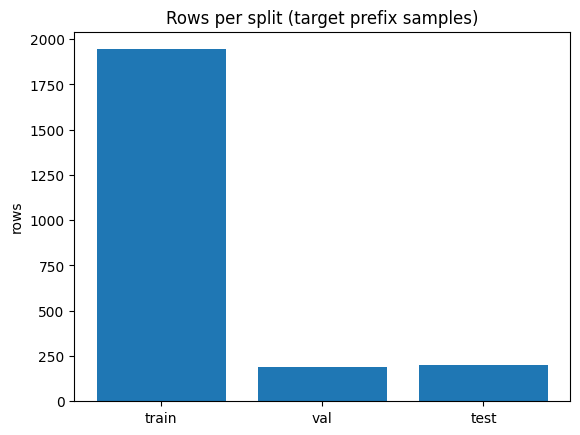

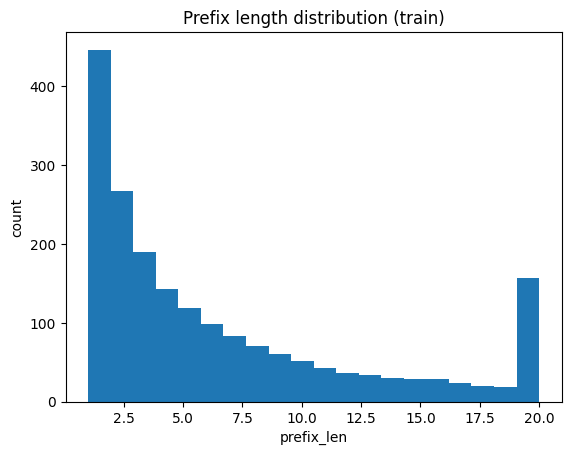

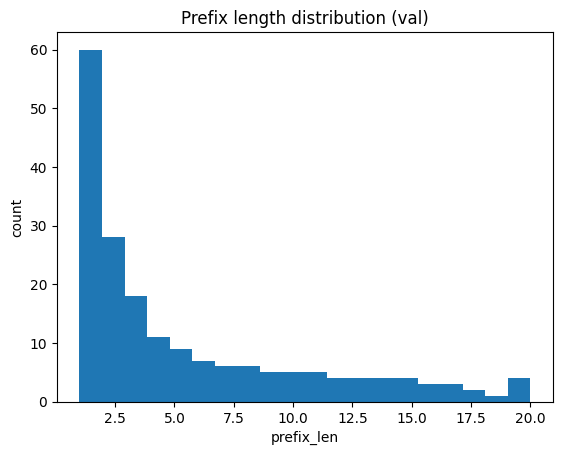

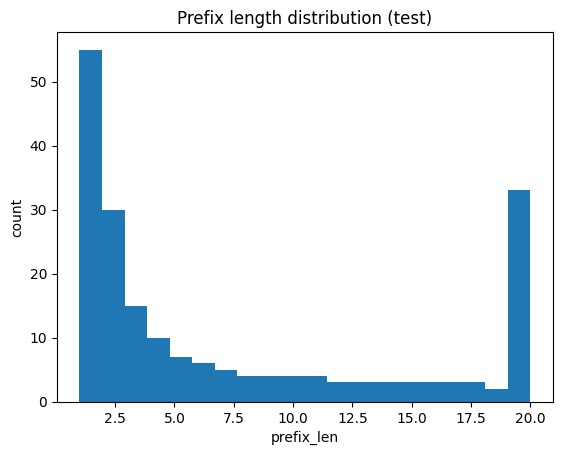

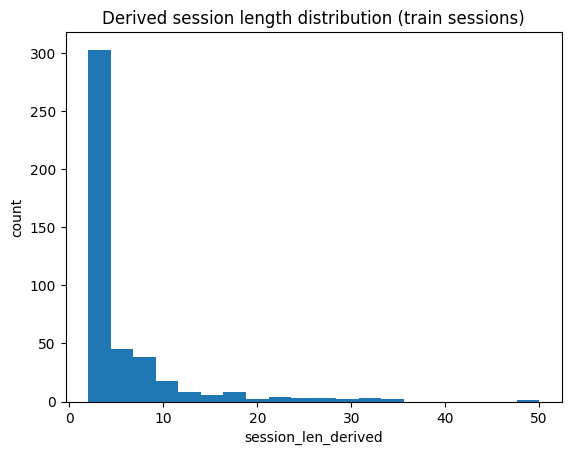

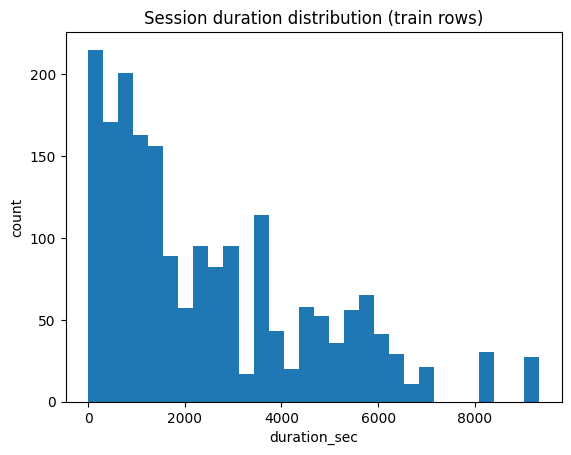

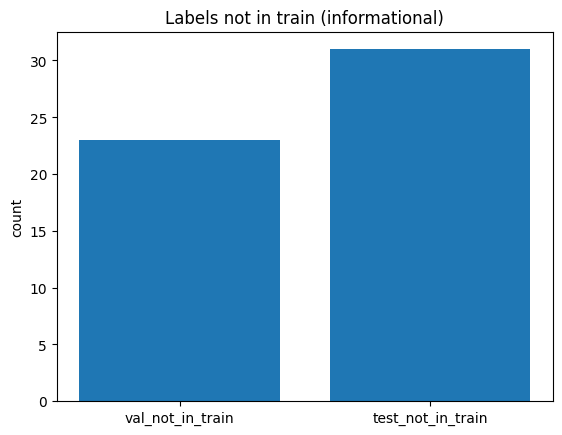

In [9]:
# [CELL 05B-07] Plots (matplotlib): split sizes, prefix_len, derived session_len, duration, OOV label coverage

import matplotlib.pyplot as plt

# 1) Split sizes (rows)
plt.figure()
plt.bar(["train","val","test"], [len(t_train), len(t_val), len(t_test)])
plt.title("Rows per split (target prefix samples)")
plt.ylabel("rows")
plt.show()

# 2) Prefix length distribution
plt.figure()
plt.hist(t_train["prefix_len"], bins=20)
plt.title("Prefix length distribution (train)")
plt.xlabel("prefix_len")
plt.ylabel("count")
plt.show()

plt.figure()
plt.hist(t_val["prefix_len"], bins=20)
plt.title("Prefix length distribution (val)")
plt.xlabel("prefix_len")
plt.ylabel("count")
plt.show()

plt.figure()
plt.hist(t_test["prefix_len"], bins=20)
plt.title("Prefix length distribution (test)")
plt.xlabel("prefix_len")
plt.ylabel("count")
plt.show()

# 3) Derived session length distribution (per session)
plt.figure()
plt.hist(sess_len_train, bins=20)
plt.title("Derived session length distribution (train sessions)")
plt.xlabel("session_len_derived")
plt.ylabel("count")
plt.show()

# 4) Session duration (seconds) distribution
dur_train = t_train["session_duration_sec"].dropna()
plt.figure()
plt.hist(dur_train, bins=30)
plt.title("Session duration distribution (train rows)")
plt.xlabel("duration_sec")
plt.ylabel("count")
plt.show()

# 5) Label coverage gaps: val/test labels not rememberable from train (informational)
train_labels = set(t_train["label_str"].unique())
val_labels   = set(t_val["label_str"].unique())
test_labels  = set(t_test["label_str"].unique())

val_not_in_train = len(val_labels - train_labels)
test_not_in_train = len(test_labels - train_labels)

plt.figure()
plt.bar(["val_not_in_train","test_not_in_train"], [val_not_in_train, test_not_in_train])
plt.title("Labels not in train (informational)")
plt.ylabel("count")
plt.show()
